### Table of contents

1. [Introduction](#intro)
2. [Getting set up](#setup)
3. [Hello World: Get customer profiles in your account](#hello_world)
4. [Example use cases](#common_uses) <br/>
    4.1 [Get data on a specific customer profile](#common_uses_1) <br/>
    4.2 [Get profiles in a list](#common_uses_2) <br/>
    4.3 [Get unsubscription events between timestamps](#common_uses_3) <br/>
    4.4 [Finding first time buyers during BFCM](#common_uses_4) <br/>
5. [Wrapping up](#conclusion)


### FAQs

- [Who is this guide meant for?](#faq_who_meant_for)
- [What do I need to follow along?](#faq_prereq)
- [What's an SDK?](#faq_sdk_info)
- [What's an API private key?](#faq_api_pk)
- [What is the general structure of Klaviyo's API responses?](#faq_api_response)
- [How is customer profile data structured specifically?](#faq_customer_data_model)
- [How are events and customer profiles related?](#faq_events_and_profiles)
- [What is a Klaviyo ID?](#faq_klaviyo_id)
- [How can I get customer profile IDs?](#faq_profile_ids)
- [How can I get list or segment IDs?](#faq_list_id)
- [What is pagination?](#faq_pagination_info)
- [What's a simple example of pagination?](#faq_pagination_example)
- [What does the links argument mean?](#faq_links_arg)
- [How can I filter events based on date?](#faq_date_filtering)

<a id='intro'></a>
## 1. Introduction

### Before we begin

Klaviyo helps businesses collect massive amounts of data on their customers from the communications they interact with to metadata from their *Active on Site* sessions. Developers play a key role in unlocking the value in this data. 

We will start by building a baseline understanding of concepts related to Klaviyo's APIs and build toward a step-by-step walkthrough of a complex use case centered around first-time, Black Friday customers. 

This guide primarily makes requests on Klaviyo's [newest generation of APIs](https://developers.klaviyo.com/en/reference/api-overview) using our Python SDK. However, direct HTTP requests are covered as well. Regardless of how you plan on interacting with Klaviyo's APIs, this guide should teach you something about how customer data in Klaviyo can be a driver for growth. Let's dive in!

<a id='faq_who_meant_for'></a>

### Who is this guide meant for?

- Anyone interested in how Klaviyo data is structured
- New Klaviyo developers
- Experienced Klaviyo developers

<a id='setup'></a>
## 2. Getting set up

<a id='faq_prereq'></a>

### What do I need to run this notebook?
- Somewhere to execute Python code
- [Klaviyo SDK installed locally](https://developers.klaviyo.com/en/docs/sdk-overview)
- [Sandbox account](https://developers.klaviyo.com/en/docs/create-a-test-account)
- [Sample data generated](https://developers.klaviyo.com/en/docs/generate-sample-data)
- [Private API Key](https://help.klaviyo.com/hc/en-us/articles/115005062267-How-to-Manage-Your-Account-s-API-Keys)

The steps listed above are needed if you want to execute the code snippets shown in this guide. Those who are mainly interested to learn how Klaviyo's APIs work should be able to get the information without needing to run the notebook.

It is not strictly necessary to have a sandbox account with fake customer data in order to run this notebook. However, developers who are testing new functionalities should strongly consider it. Especially for use cases where you upload or change customer data, you want to make sure that you are not negatively impacting the data you have on your customers.

<a id='faq_sdk_info'></a>

### What's an SDK?

If you haven't worked with SDKs before (Software Development Kits), think of an SDK like a small library specific to a set of API endpoints.

Klaviyo's SDKs make working with our APIs easier by providing one-line methods for common tasks (e.g. how to update a customer's profile, change subscription status, etc.). 

This walkthrough will make use of the Python language and Klaviyo's Python SDK. Klaviyo has released SDKs in `Node`, `PHP`, `Python`, and `Ruby`. Developers can find [more information about Klaviyo's SDKs here.](https://developers.klaviyo.com/en/docs/sdk-overview)

If you are using one of those languages, Klaviyo highly recommends that you use our SDK to make API requests. The SDK performs a lot of best practices automatically under the hood (e.g. retry logic).

If you want to fully customize every part of your usage of our APIs, you are always free to make the calls directly (i.e. through HTTP requests).

This guide covers both direct API requests and requests sent through Klaviyo's SDK.

### Import SDK Client

This tutorial assumes that Klaviyo's SDK is already set up locally. To check out how this is done, [select the SDK version and language](https://developers.klaviyo.com/en/docs/sdk-overview) you want and follow the instructions given on the SDK github. For reference, you can download the SDK with a `pip install` call like the one commented out below.

Setting up the SDK locally in your codebase is most important for frequent API users and/or developers setting up a production job. Developers who are just testing Klaviyo's API capabilities can start with direct HTTP requests on Klaviyo's endpoints. 

### This guide is best viewed on NBViewer

For the best user experience reading this guide, please view it on NBViewer rather than natively in Github. Interacting with the guide on NBviewer cuts down on 404 errors when clicking internal links and better formats long code printouts.

You can find [Klaviyo's API guides on NBViewer here](https://nbviewer.org/github/klaviyo-labs/klaviyo-api-guides-public).

In [1]:
# you may need to pip install the SDK for Klaviyo's current generation of APIs
# pip install klaviyo-api

In [2]:
### Libraries needed to run requests through pure python (using requests library)
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from datetime import datetime, timedelta
import random
import string
import json


### Library needed to run request through Klaviyo's python SDK 
from klaviyo_api import KlaviyoAPI

<a id='faq_api_pk'></a>

### What is a private API key?

To query your customer data using Klaviyo's APIs, you will need to authenticate that request with a private API key. 

A Klaviyo private API key is an authentication token that developers need to pass on most API calls to show that they have the proper permission. A private API key lets developers use API requests to do many actions usually only available manually in Klaviyo (e.g. downloading data and viewing customer orders).

That's why it is critically important to treat private API keys like passwords. They should not be publicly viewable anywhere (e.g. on your github, on your website's frontend). Developers should also consider limiting access to these keys internally in the same way that they would limit who has access to an account password.

Klaviyo accounts do not start with a private API key, they have to be generated. You can learn about how to generate a Klaviyo private API key on our [Help Center](https://help.klaviyo.com/hc/en-us/articles/115005062267-How-to-Manage-Your-Account-s-API-Keys).

### Get your private API key

To run any of the API requests in this guide, you will need a private API key. For HTTP requests, this private API key is passed as an Authorization header. For SDK requests, the private key is part of the information needed to define a SDK client object.

To execute the code snippets in this notebook, please replace the [private API key](https://help.klaviyo.com/hc/en-us/articles/115005062267-How-to-Manage-Your-Account-s-API-Keys) placeholder with your account's key.

In [3]:
# TODO: Update private_key
private_key = 'PRIVATE_API_KEY'

# NOTE: This key cannot exist in a public place. Do not push a script publicly with this key in it.

### Create SDK Client

Now that we have imported the SDK and set an account's private API key, we next have to instantiate an SDK client.
This SDK client is an intermediary between you and Klaviyo's APIs that will make your life easier.

An SDK client is necessary to run most of the examples covered in this guide.

Once this has been run, you will be able to make API requests simply by running the client object's methods.

In [4]:
# Instantiate the SDK client with your private API key
klaviyo = KlaviyoAPI(private_key, max_delay=5, max_retries=3)

### Adjust Display Settings

The `HTML` code snippet below has nothing to do with Klaviyo's APIs. It simply makes the notebook render better on NBViewer.

In [5]:
%%html
<style>
.nbviewer div.output_area {
  overflow-y: auto;
  max-height: 500px; /* or value of your choosing */
}
</style>

<a id='hello_world'></a>
## 3. Hello World: Get your customer profiles

Now that we've created an SDK client authorized with your Klaviyo private API key, it's time to explore your data.

Getting your account's customer profiles is a great way to get introduced to Klaviyo's data model. We will show how to make that call both through Klaviyo's SDK and through a direct HTTP request. Both methods lead to the same result.

As a reminder, Klaviyo recommends you scope new functionality with a [sandbox account](https://developers.klaviyo.com/en/docs/create-a-test-account) filled with [sample data](https://developers.klaviyo.com/en/docs/generate-sample-data).

### Hello World: SDK Version

The code block below shows how to do this API call using Klaviyo's SDK. It leads to the same results as a HTTP example below.

In [6]:
# NOTE: Does not include pagination (see Example 3.2); so, will not return all customers.
output = klaviyo.Profiles.get_profiles()
output

{'data': [{'type': 'profile',
   'id': '01G111X7K5VMWZR03WV4MHRDAV',
   'attributes': {'email': 'kristina.stephens_138@klaviyo-demo.com',
    'phone_number': '+18409121959',
    'external_id': None,
    'anonymous_id': None,
    'first_name': 'Kristina',
    'last_name': 'Stephens',
    'organization': None,
    'title': None,
    'image': None,
    'created': '2022-04-19T13:59:05+00:00',
    'updated': '2022-04-19T14:01:10+00:00',
    'last_event_date': None,
    'location': {'address1': None,
     'address2': None,
     'city': 'Columbus',
     'country': 'United States',
     'latitude': None,
     'longitude': None,
     'region': 'Ohio',
     'zip': '18335',
     'timezone': 'America/New_York'},
    'properties': {}},
   'links': {'self': 'https://a.klaviyo.com/api/profiles/01G111X7K5VMWZR03WV4MHRDAV/'},
   'relationships': {'lists': {'links': {'self': 'https://a.klaviyo.com/api/profiles/01G111X7K5VMWZR03WV4MHRDAV/relationships/lists/',
      'related': 'https://a.klaviyo.com/api/

### Hello World: HTTP Version

The code block below shows how to accomplish this API call using a direct HTTP request. It leads to the same results as a SDK example above.

If you want to see more simple HTTP code snippets, you should look through [Klaviyo's API documentation](https://developers.klaviyo.com/en/reference/get_profiles). It has examples of how to make direct API calls on each of Klaviyo's endpoints in a number of frameworks including `JavaScript`, `Node`, `Python`, `Java`, `PHP`, and `Shell` among others.

In [7]:
# NOTE: Does not include pagination (see Example 3.2); so, will not return all customers.

# The headers for a direct call on the endpoint should look similar to this (with an updated revision date)
headers = {
    "accept": "application/json",
    "revision": "2022-10-17",
    "Authorization": "Klaviyo-API-Key " + private_key
}

# specify the endpoint you want to hit
url = "https://a.klaviyo.com/api/profiles/"

# execute the request
response = requests.request("GET", 
                            url, 
                            headers=headers)

# convert json string to dictionary
response_dict = json.loads(response.text)
response_dict

{'data': [{'type': 'profile',
   'id': '01G111X7K5VMWZR03WV4MHRDAV',
   'attributes': {'email': 'kristina.stephens_138@klaviyo-demo.com',
    'phone_number': '+18409121959',
    'external_id': None,
    'anonymous_id': None,
    'first_name': 'Kristina',
    'last_name': 'Stephens',
    'organization': None,
    'title': None,
    'image': None,
    'created': '2022-04-19T13:59:05+00:00',
    'updated': '2022-04-19T14:01:10+00:00',
    'last_event_date': None,
    'location': {'address1': None,
     'address2': None,
     'city': 'Columbus',
     'country': 'United States',
     'latitude': None,
     'longitude': None,
     'region': 'Ohio',
     'zip': '18335',
     'timezone': 'America/New_York'},
    'properties': {}},
   'links': {'self': 'https://a.klaviyo.com/api/profiles/01G111X7K5VMWZR03WV4MHRDAV/'},
   'relationships': {'lists': {'links': {'self': 'https://a.klaviyo.com/api/profiles/01G111X7K5VMWZR03WV4MHRDAV/relationships/lists/',
      'related': 'https://a.klaviyo.com/api/

<a id='faq_api_response'></a>

### How are Klaviyo's API responses structured?

As you can see, the data is returned in a nested dictionary format (i.e. a JSON). The core information that we requested for this call lives in the `data` field. 

The `data` field can take different forms depending on the data being queried. For example, the `data` field can map to a dictionary or a list of dictionaries depending on whether you are querying a single record or many.

Klaviyo's response for a GET request returning multiple records has the following form:

```python

# response dictionary
{
    'data': [
        record_dict_1,
        record_dict_2,
        ...,
        record_dict_n
    ],
    'links': {
        ... # links not shown. Explained further in Example 4.2
    }
}
```

The content and schema of these record dicts depend on the data being requested. Regardless of the data queried, all Klaviyo API responses should follow the form shown above with a `data` field containing the content of the request and a `links` field containing pagination metadata. 

Now that we have a better understanding of how API responses are structured generally, let's take a look at how the `record_dicts` can be structured.

<a id='faq_customer_data_model'></a>

### How is the customer profile data model structured specifically?

The `data` field in an API response maps to a dictionary or list of dictionaries. The content and schema for the dicts themselves is dependent on the type of record being requested.

Let's take a look at how customer profile dicts are structured since they are the subject of this *Hello World* example. The core information about a customer account exists in the `attributes` field.

```python
# this is the schema for data on an individual customer profile
{
  "type": "profile",
  "id": "string",
  "attributes": {
    "email": "string",
    "phone_number": "string",
    "external_id": "string",
    "anonymous_id": "string",
    "first_name": "string",
    "last_name": "string",
    "organization": "string",
    "title": "string",
    "image": "string",
    "created": "string (UTC-formatted datetime)",
    "updated": "string (UTC-formatted datetime)",
    "last_event_date": "string (UTC-formatted datetime)",
    "location": {
      "address1": "string",
      "address2": "string",
      "city": "string",
      "country": "string",
      "latitude": "string",
      "longitude": "string",
      "region": "string",
      "zip": "string",
      "timezone": "string"
    },
    "properties": {} # holds any custom attributes
  },
  ... # links and relationships not shown
}
```

Profiles in Klaviyo's database contain core attributes about these customers (e.g. address, name, communication methods) as well as unique profiles identifiers. One such identifier is a profile's Klaviyo ID, which shows up under the `id` field as a 26 character string.

If you have questions about how events or profiles are structured or what field names refer to, please consult [Klaviyo's API documentation](https://developers.klaviyo.com/en/reference/get_profiles)

<a id='faq_events_and_profiles'></a>

### How are events and profiles related?

*Events* and *profiles* have each been mentioned throughout this guide. Let's clarify what these terms mean.

A customer profile is a set of information unique to each of the customers of your business. Events are things that happen related to these customers (e.g. product orders or email delivery). 

These events usually have data describing the specifics of what happened. For example, an *Ordered Product* event captures information about the product price, product name, time of purchase, among other information. 

Each event is associated with a single customer profile. Profiles, however, can be associated with many events. 

You can learn more about [customer profiles](https://help.klaviyo.com/hc/en-us/articles/115005247088-Understanding-profiles-in-Klaviyo), [events](https://help.klaviyo.com/hc/en-us/articles/115005076747), and [metrics](https://help.klaviyo.com/hc/en-us/articles/115005076787-Guide-to-Managing-Your-Metrics) from Klaviyo's help center.

Customer events can be viewed in Klaviyo or retrieved with an API call. To make this more clear, below is a screenshot showing a single customer's timeline of events:

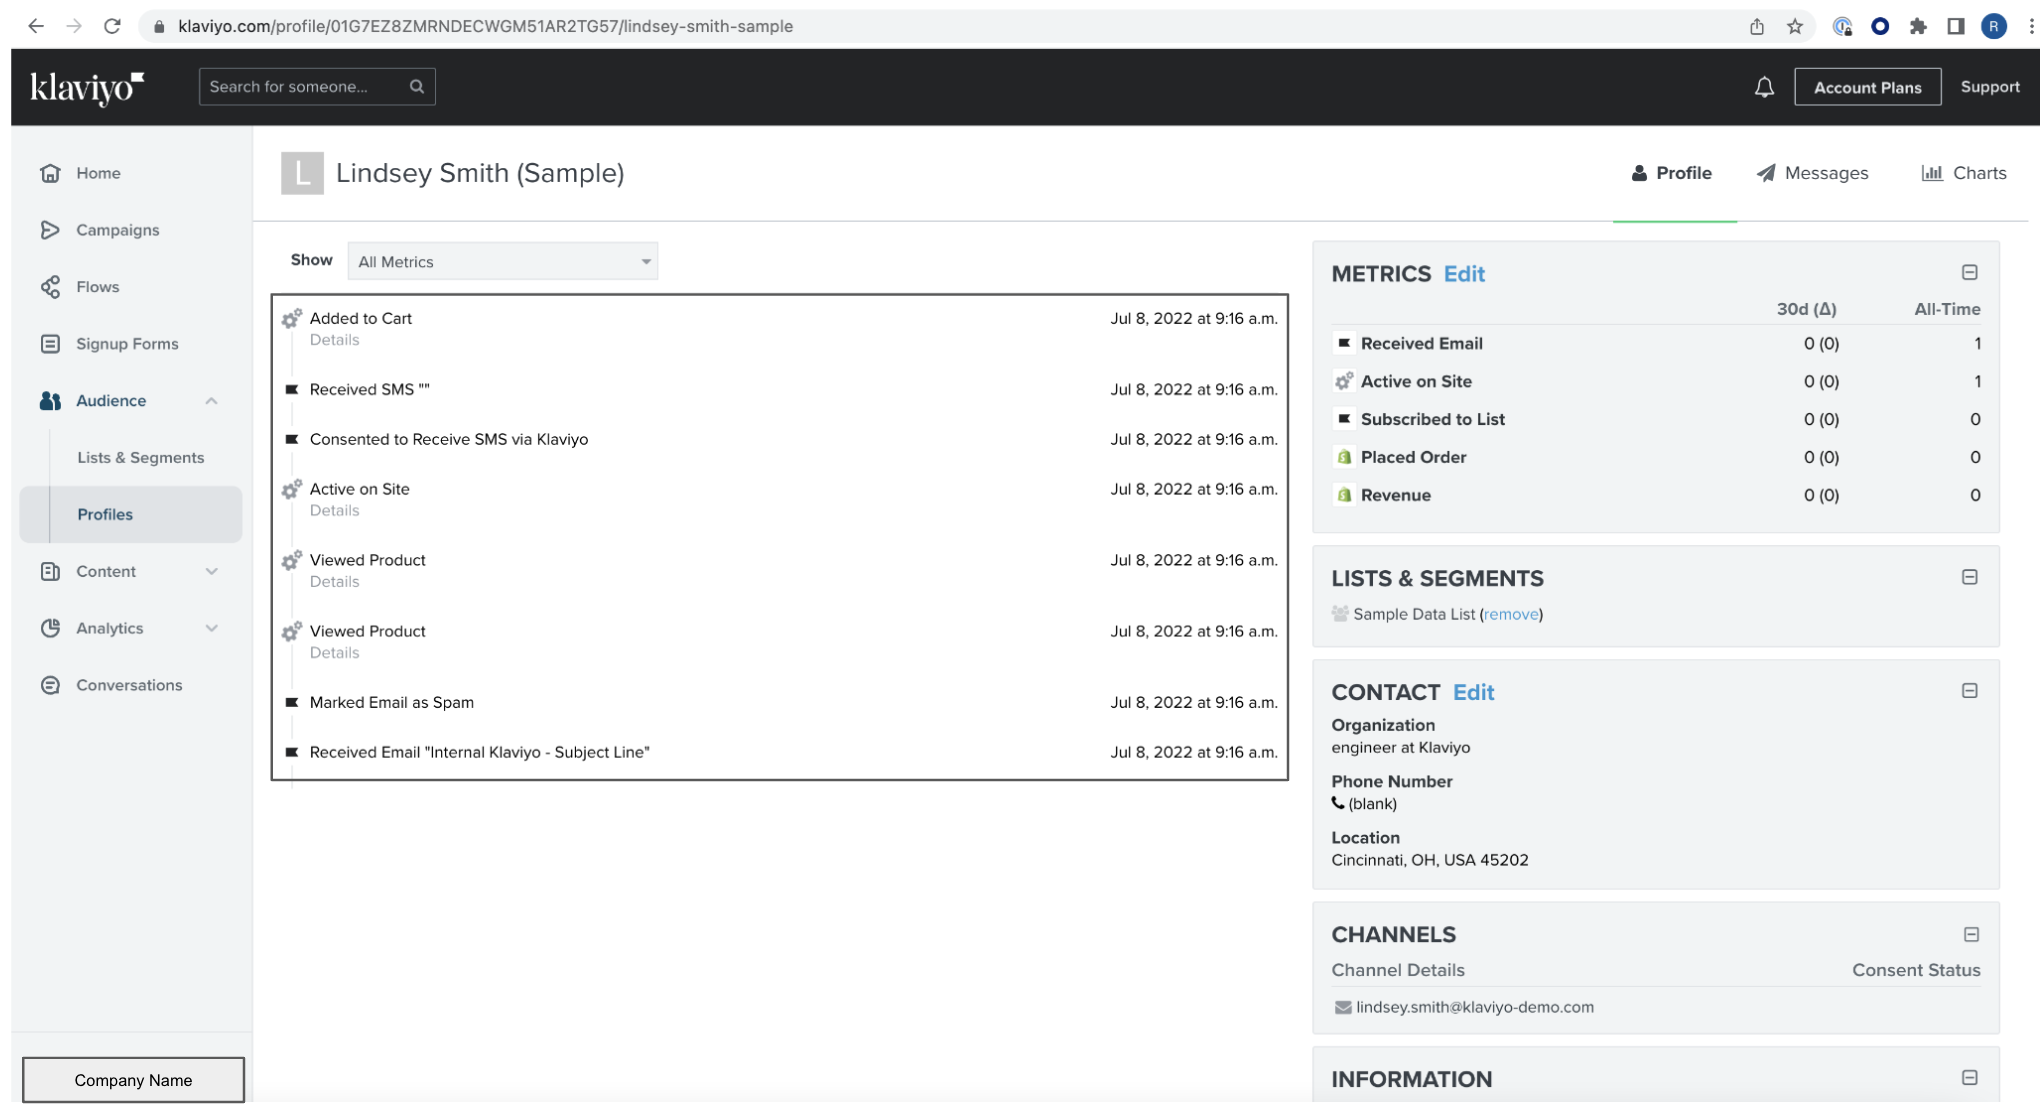

<a id='common_uses'></a>
## 4. Example use cases

<a id='common_uses_1'></a>
### 4.1 Get data on a specific customer profile

The *Hello World* section covered how to pull customer account data generally. But now let's say you want information on a single customer account. This can be done with a call to Klaviyo's SDK.

To make that call, though, we would need the customer profile's Klaviyo ID.

<a id='faq_klaviyo_id'></a>

#### What is a Klaviyo ID? How does it differ from an external ID?

Each customer profile in your account has a [Klaviyo ID](https://help.klaviyo.com/hc/en-us/articles/360053679071-Profiles-and-Properties-Glossary#k6) assigned to it. This is a unique identifier managed by Klaviyo, which can be used to identify customer profiles. In Klaviyo's API responses, a profile's Klaviyo ID shows up under the `id` field. You can use an account's Klaviyo ID to identify customer profile

[External IDs](https://help.klaviyo.com/hc/en-us/articles/360053679071-Profiles-and-Properties-Glossary#i5), on the other hand, are managed by you, and not Klaviyo. Customer profiles do not automatically start with an external ID. You can use the external ID field to hold string identifiers of up to 64 characters. A profile's external ID shows up under the `external_id` field. 

The `/profiles` endpoint expects a Klaviyo ID to identify customer profiles.

<a id='faq_profile_ids'></a>

#### Where can I get a profile's Klaviyo ID?

You can get a profile's Klaviyo ID from within Klaviyo or from the `id` field returned by Klaviyo's APIs (shown in the schema above).

Let's take a closer look at how to get that same information in Klaviyo.

#### Getting Klaviyo IDs manually
Step 1: Go into your Klaviyo account and select the **Profiles** tab. Click on a customer you want to pull data on.

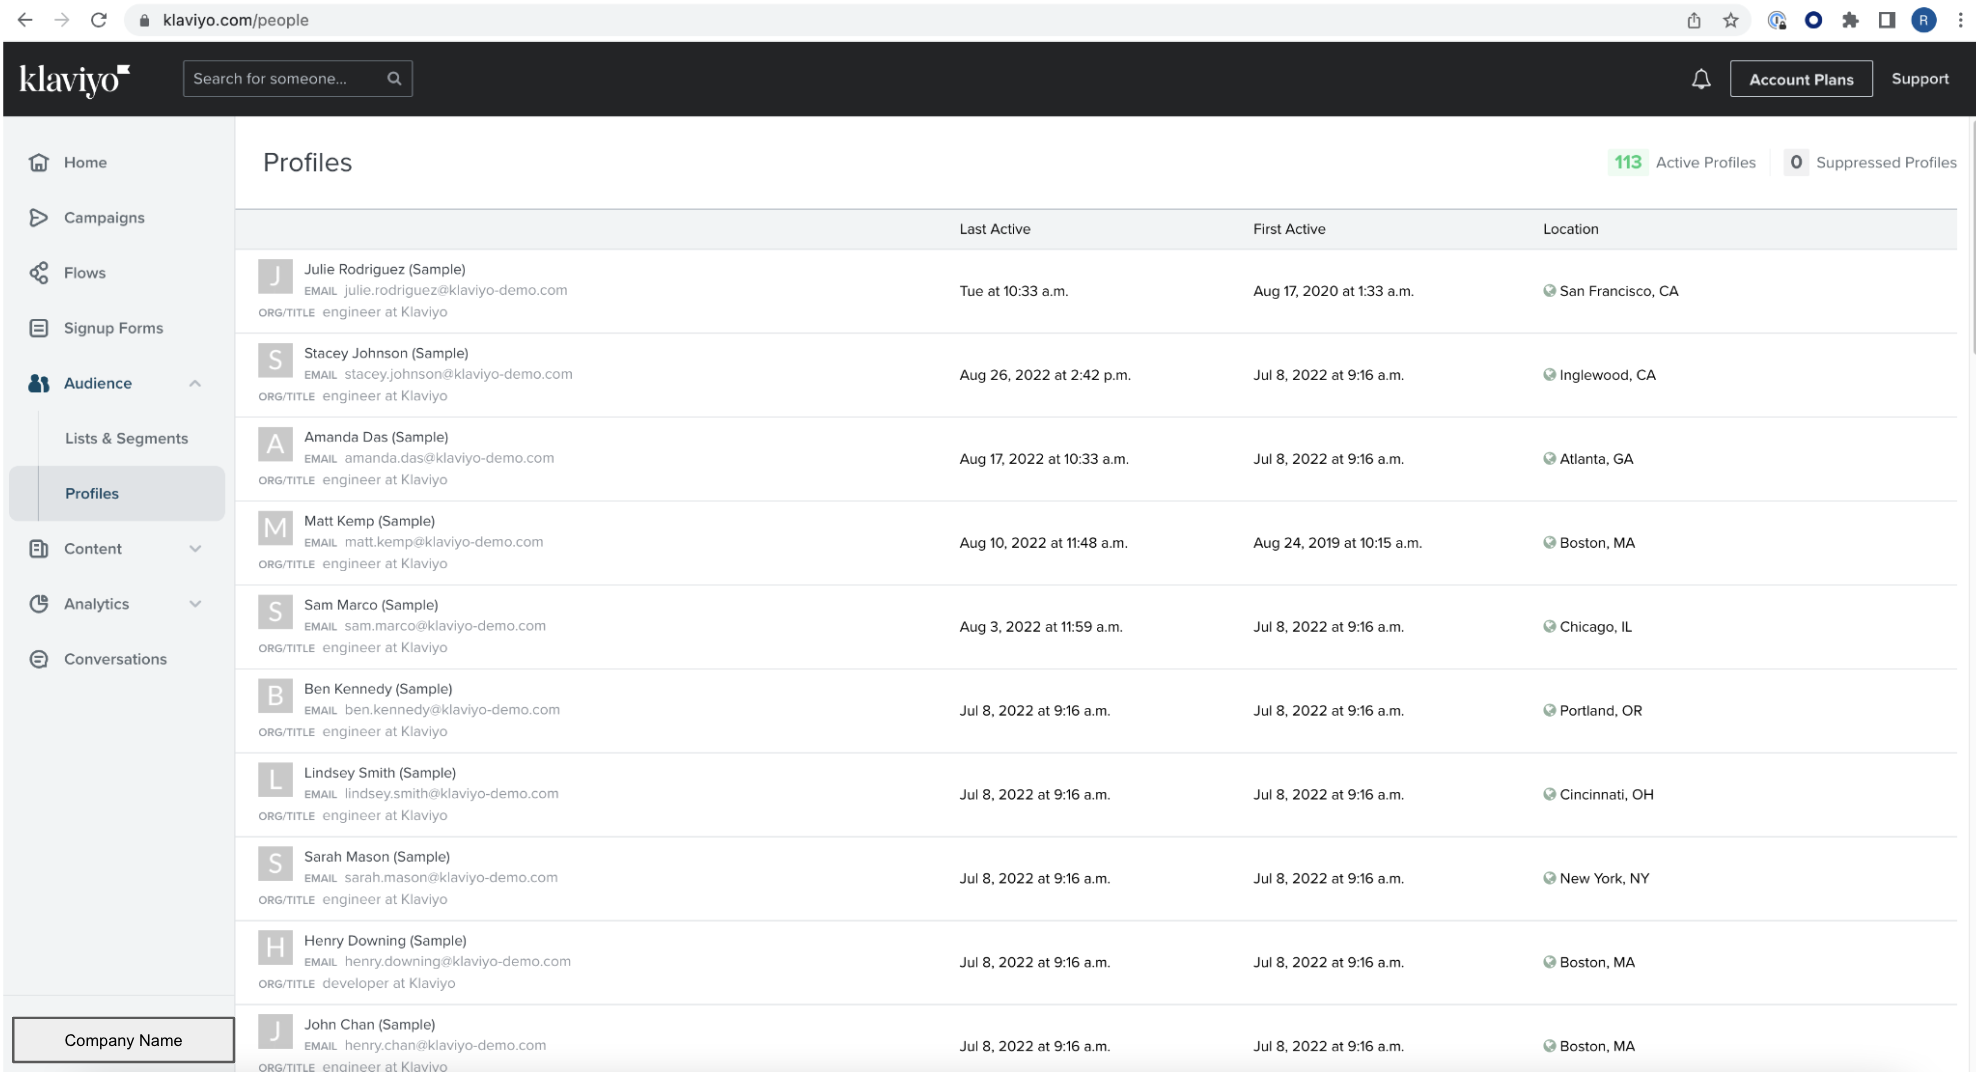

Step 2: The selected profile will have a profile_id embedded into the URL. This will show up as either a 6-character or 26-character long, alphanumeric string.

Find a customer account with event history and copy and paste their Klaviyo ID into the `profile_id` variable below. 

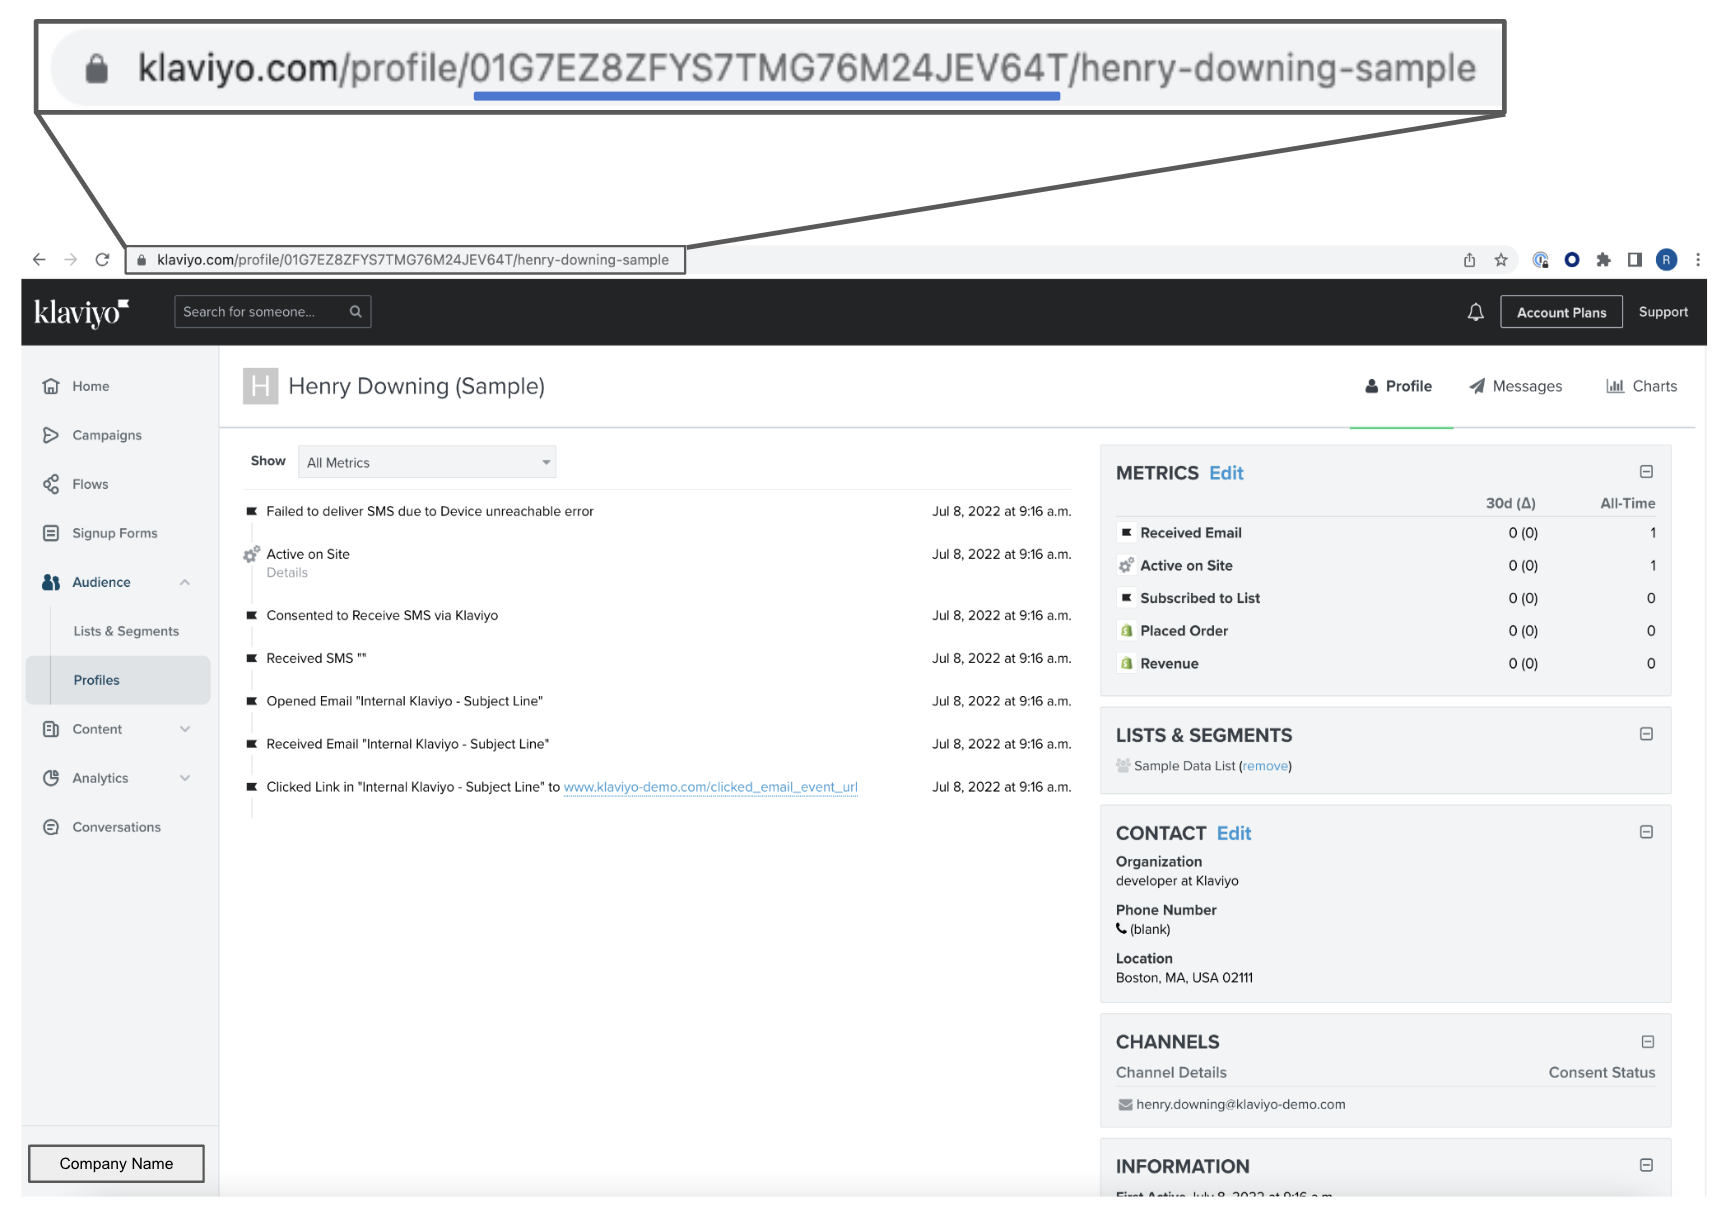

In [8]:
# TODO: replace this with your own id
profile_id = 'YOUR-PROFILE-ID'

#### Execute the API call

In [9]:
klaviyo.Profiles.get_profile(profile_id)

{'data': {'type': 'profile',
  'id': '01G7EZ8ZFYS7TMG76M24JEV64T',
  'attributes': {'email': 'henry.downing@klaviyo-demo.com',
   'phone_number': None,
   'external_id': None,
   'anonymous_id': None,
   'first_name': 'Henry',
   'last_name': 'Downing (Sample)',
   'organization': 'Klaviyo',
   'title': 'developer',
   'image': None,
   'created': '2022-07-08T13:16:37+00:00',
   'updated': '2022-07-08T13:16:38+00:00',
   'last_event_date': '2022-07-08T13:16:38+00:00',
   'location': {'address1': '225 Franklin St',
    'address2': '6th floor',
    'city': 'Boston',
    'country': 'USA',
    'latitude': None,
    'longitude': None,
    'region': 'MA',
    'zip': '02111',
    'timezone': None},
   'properties': {'$latitude': '42.3559',
    '$longitude': '71.0537',
    'klaviyo_sample_data_gen': True}},
  'links': {'self': 'https://a.klaviyo.com/api/profiles/01G7EZ8ZFYS7TMG76M24JEV64T/'},
  'relationships': {'lists': {'links': {'self': 'https://a.klaviyo.com/api/profiles/01G7EZ8ZFYS7TMG76M

By calling `klaviyo.Profiles.get_profile()` with a specific profile's Klaviyo ID, we were able to successfully pull that customer's account information. Note how the API response and customer profile schema follow the pattern described in the *Hello World* section.

Klaviyo's help center has a [more thorough article](https://help.klaviyo.com/hc/en-us/articles/115005247088-Understanding-profiles-in-Klaviyo) covering how customer profiles are structured

<a id='common_uses_2'></a>
### 4.2 Get profiles in a list

**Lists & Segments** are a core part of Klaviyo. Lists are generally static groupings of profiles while segments are dynamically updated based on customer attributes. New developers can explore how **Lists & Segments** work in Klaviyo in our [help center article.](https://help.klaviyo.com/hc/en-us/categories/115000867867-Lists-Segments)

Companies using Klaviyo often need to pull customer accounts belonging to a given list or segment. Let's see how you can do this programmatically with Klaviyo's APIs.

<a id='faq_list_id'></a>

#### Get a list ID or segment ID

A list ID or segment ID is a six digit, alphanumeric string used to uniquely identify the given list or segment. The process for getting one of these identifiers is similar to the process of getting a Klaviyo ID.

You can either get this [manually in Klaviyo](https://help.klaviyo.com/hc/en-us/articles/115005078647-How-to-find-a-list-ID) or [programmatically with Klaviyo's APIs](https://github.com/klaviyo/klaviyo-python-sdk-beta#get-lists). To keep this guide brief, these methods are not repeated.

#### Execute API call to get list profiles

Now that we've identified the target list, the next step is another SDK one-liner to grab the profiles in the list.

In [10]:
# TODO: Update with your list_id
list_id = 'YOUR-LIST-ID'

# Note: Pagination not implemented (see below)
response_dict = klaviyo.Lists.get_list_profiles(list_id)

# print(response)
print('length of results', len(response_dict['data']))

# display output
response_dict

length of results 10


{'data': [{'type': 'profile',
   'id': '01G111X7K5VMWZR03WV4MHRDAV',
   'attributes': {'email': 'kristina.stephens_138@klaviyo-demo.com',
    'phone_number': '+18409121959',
    'external_id': None,
    'anonymous_id': None,
    'first_name': 'Kristina',
    'last_name': 'Stephens',
    'organization': None,
    'title': None,
    'image': None,
    'created': '2022-04-19T13:59:05+00:00',
    'updated': '2022-04-19T14:01:10+00:00',
    'last_event_date': None,
    'location': {'address1': None,
     'address2': None,
     'city': 'Columbus',
     'country': 'United States',
     'latitude': None,
     'longitude': None,
     'region': 'Ohio',
     'zip': '18335',
     'timezone': 'America/New_York'},
    'properties': {}},
   'links': {'self': 'https://a.klaviyo.com/api/profiles/01G111X7K5VMWZR03WV4MHRDAV/'}},
  {'type': 'profile',
   'id': '01G111X7VE1V41ZM36X2NKV02F',
   'attributes': {'email': 'julia.dixon_222@klaviyo-demo.com',
    'phone_number': '+18470101517',
    'external_id':

<a id='faq_pagination_info'></a>

#### Wait, why aren't all of my results showing up? 

The list used in the example above has 100 profiles in it. However, the API only returned 10 profiles. Why don't all the profiles show up?

This is a common question that new developers run into. 

When you query many records at once using Klaviyo's APIs -- for example, querying a large list -- the results are returned in small chunks rather than all at once. To see all the profiles in the list, you have to iterate over the pages of your query's results. This process is called pagination.

#### Why do Klaviyo's APIs have pagination?

Pagination is an important feature of Klaviyo's APIs meant to lower response times, reduce errors, and protect accounts from running into rate limit issues. 

Klaviyo API responses natively return information in the `links` argument to make the process of pagination easier. This is best seen through example.

#### How do I paginate using Klaviyo's APIs?

Standard in all Klaviyo API returns is the `links` argument, which has the following form:

```python
response = {'data': {...},
            ...,
            'links': {
                'self': URL_STRING,
                'next': URL_STRING or NoneType,
                'previous': URL_STRING or NoneType
            }
}
```

<a id='faq_links_arg'></a>

This `links` key maps to the information you will need to execute pagination.

Specifically, if you are trying to access 100 records, 10 records at a time, it would look like the following:


```python
# Page 1 of results (original GET request)
'links': {
    'self': URL_STRING_1_to_10,
    'next': URL_STRING_11_to_20,
    'previous': None
}

# Page 2 of results (GET request on URL_STRING_11_to_20)
'links': {
    'self': URL_STRING_11_to_20,
    'next': URL_STRING_21_to_30,
    'previous': URL_STRING_1_to_10
}

... # Pages [3,4,5,6,7,8,9]

# Page 10 of results (GET request on URL_STRING_91_to_100)
'links': {
    'self': URL_STRING_91_to_100,
    'next': None,
    'previous': URL_STRING_81_to_90
}
```

Therefore, pagination can be succinctly expressed as a while loop searching for when `response['links']['next'] is None`.

#### Some SDKs require parsing the URL string

If you are interacting with Klaviyo's endpoint directly through HTTP, you can simply make a `GET` request on the URL strings returned in the `links` argument.

If you are using Klaviyo's `Python` or `PHP` SDK, you can take the URL string returned and pass it directly to the [SDK's page_cursor argument](https://github.com/klaviyo/klaviyo-api-python#get-list-profiles).

However, if you are using an SDK in `Node` or `Ruby`, then there is an extra step involved. You will need to parse the URL string to grab the page cursor embedded in the URL.

Note that `URL_STRINGs` provided by the `links` argument have any of the following formats:

- `https://a.klaviyo.com/.../endpoint/?page%5Bcursor%5D=PAGE_CURSOR_ID`
- `https://a.klaviyo.com/.../endpoint/?filter=...&page%5Bcursor%5D=PAGE_CURSOR_ID`
- `https://a.klaviyo.com/.../endpoint/?filter=...&page%5Bcursor%5D=PAGE_CURSOR_ID&sort=...`

So, a helper function to parse `PAGE_CURSOR_ID` from any of those strings (in Python) could look like the following:

```python
def get_page_cursor_from_url(next_url):
    page_cursor = next_url.split('cursor%5D=')[1].split('&')[0]
    return page_cursor
```

<a id='faq_pagination_example'></a>

#### Let's paginate through profiles in a large list

Now all those logistics are out of the way, let's see how we can execute a while loop to get all the data that our API request applies to.

Note that if you are querying a very large amount of data, you should be aware that Klaviyo's APIs have [rate limits](https://developers.klaviyo.com/en/docs/rate_limits_and_error_handling#rate-limits). Built into Klaviyo's SDK instantiation is customizable retry logic, which should help developers avoid 429 errors in most cases.

In [11]:
results_list = []

# TODO: Update with your list_id
list_id = 'YOUR-LIST-ID'

response = klaviyo.Lists.get_list_profiles(list_id)

results_list.extend(response['data'])
next_url = response['links']['next']

while next_url is not None:
    
    response = klaviyo.Lists.get_list_profiles(list_id, page_cursor=next_url)
    results_list.extend(response['data'])
    next_url = response['links']['next']
    
print('length of results', len(results_list))
print(results_list)

length of results 100
[{'type': 'profile', 'id': '01G111X7K5VMWZR03WV4MHRDAV', 'attributes': {'email': 'kristina.stephens_138@klaviyo-demo.com', 'phone_number': '+18409121959', 'external_id': None, 'anonymous_id': None, 'first_name': 'Kristina', 'last_name': 'Stephens', 'organization': None, 'title': None, 'image': None, 'created': '2022-04-19T13:59:05+00:00', 'updated': '2022-04-19T14:01:10+00:00', 'last_event_date': None, 'location': {'address1': None, 'address2': None, 'city': 'Columbus', 'country': 'United States', 'latitude': None, 'longitude': None, 'region': 'Ohio', 'zip': '18335', 'timezone': 'America/New_York'}, 'properties': {}}, 'links': {'self': 'https://a.klaviyo.com/api/profiles/01G111X7K5VMWZR03WV4MHRDAV/'}}, {'type': 'profile', 'id': '01G111X7VE1V41ZM36X2NKV02F', 'attributes': {'email': 'julia.dixon_222@klaviyo-demo.com', 'phone_number': '+18470101517', 'external_id': None, 'anonymous_id': None, 'first_name': 'Julia', 'last_name': 'Dixon', 'organization': None, 'title':

<a id='common_uses_3'></a>
### 4.3 Get unsubscription events between timestamps

This task requires a few steps.

1. Get metric_ids of unsubscribed events
2. Pull unsubscribe events with a filter parameter
3. Pull all unsubscribe events with a filter parameter and pagination

Developers should note that this task can be done through a few endpoints. In this example we will explore an implementation primarily using the `\events` endpoint.

#### Step 1: Get metric_ids of unsubscribed events

In [12]:
for metric in klaviyo.Metrics.get_metrics()['data']:
    
    if metric['attributes']['name'] == 'Unsubscribed':
        email_unsub_metric_id = metric['id']
        
    elif metric['attributes']['name'] == 'Unsubscribed from SMS':
        sms_unsub_metric_id = metric['id']
        
print(email_unsub_metric_id, sms_unsub_metric_id)

TzsTNe RWaivf


Note that the metric_ids returned for your account will be different than the ones shown above. Metric IDs are unique between accounts.

<a id='faq_date_filtering'></a>

#### Step 2: Pull unsubscribe events with a filter parameter

Note: The code below uses a filtering argument to tell Klaviyo's API what types of events we want pulled.

See here for a more in-depth description about [how the filtering parameter works.](https://developers.klaviyo.com/en/v2022-09-07.pre/docs/beta-api-overview#filtering)

Each endpoint has different fields that can be used to filter outputs. [Klaviyo's API documentation](https://developers.klaviyo.com/en/v2022-09-07.pre/reference/get_events) is the best place to see what fields can be passed in the filter query parameter.

In [13]:
# Note: does not include pagination (see step 3)
date_start_str = '2022-07-01T00:00:00'
date_end_str = '2022-08-16T00:00:00'

# Filter here is read as "A and B and C". 
# Note that datetime strings are UTC and strings like metric_id need quotes surrounding
sms_unsub_filter = "greater-than(datetime,{}),less-than(datetime,{}),equals(metric_id,'{}')"\
                        .format(date_start_str, date_end_str, sms_unsub_metric_id)

email_unsub_filter = "greater-than(datetime,{}),less-than(datetime,{}),equals(metric_id,'{}')"\
                        .format(date_start_str, date_end_str, email_unsub_metric_id)
    

unsubscribed_sms_events = klaviyo.Events.get_events(filter=sms_unsub_filter)
unsubscribed_email_events = klaviyo.Events.get_events(filter=email_unsub_filter)

#### View the structure of these outputs

In [14]:
unsubscribed_sms_events

{'data': [{'type': 'event',
   'id': '3sUU4MFTfZS',
   'attributes': {'metric_id': 'RWaivf',
    'profile_id': '01G7EZ8ZQ6WYC95XX7K4QKMPSF',
    'timestamp': 1657286198,
    'event_properties': {'$message': '01G7EZ90R53GGPRKJSXNYSABEP',
     'extra': {'From City': 'Boston',
      'From Country': 'US',
      'From State': 'MA',
      'Inbound Message ID': '02FYSJBBFPZKEMPAQ9NNRTCC14',
      'Message ID': '01G7EZ90R53GGPRKJSXNYSABEP'},
     'From Number': '+15005550006',
     'From Phone Region': 'US',
     'Message Body': 'Stop',
     'Method': 'text',
     'To Number': '55896',
     'To Phone Region': 'US',
     '$event_id': 'sample_data_gen:b144f140-1a4e-43af-b3e8-ddf3bf211ed0'},
    'datetime': '2022-07-08 13:16:38+00:00',
    'uuid': '32bbff00-fec0-11ec-8001-11af83f24c98'},
   'links': {'self': 'https://a.klaviyo.com/api/events/3sUU4MFTfZS/'}}],
 'links': {'self': 'https://a.klaviyo.com/api/events/?filter=greater-than%28datetime%2C2022-07-01T00%3A00%3A00%29%2Cless-than%28datetime%2C

In [15]:
unsubscribed_email_events

{'data': [{'type': 'event',
   'id': '3sUSMjZwSMn',
   'attributes': {'metric_id': 'TzsTNe',
    'profile_id': '01G7EZ8ZJCM4V7CBQ4QSF4916C',
    'timestamp': 1657286197,
    'event_properties': {'$message': 'Rkp66a',
     'Campaign Name': 'Internal Klaviyo - Test Campaign Name',
     'Email Domain': 'klaviyo-demo.com',
     'Subject': 'Internal Klaviyo - Subject Line',
     '$event_id': 'sample_data_gen:bb5f44dd-fae2-41a8-a1b8-4cccbea3b7fc'},
    'datetime': '2022-07-08 13:16:37+00:00',
    'uuid': '32236880-fec0-11ec-8001-075bd83ca1b2'},
   'links': {'self': 'https://a.klaviyo.com/api/events/3sUSMjZwSMn/'}}],
 'links': {'self': 'https://a.klaviyo.com/api/events/?filter=greater-than%28datetime%2C2022-07-01T00%3A00%3A00%29%2Cless-than%28datetime%2C2022-08-16T00%3A00%3A00%29%2Cequals%28metric_id%2C%27TzsTNe%27%29',
  'next': None,
  'prev': None}}

#### Step 3: Pull all unsubscribe events with a filter parameter and pagination

With the given test account and parameters, there was only a single unsubscribe for each email and SMS. Looking at this output, developers certainly would not need to implement pagination. 

For larger accounts though, these events may stretch into the thousands. Below is another example of how developers can implement pagination (similar to how it was implemented in Example 3.2). 

In the interest of brevity, this only shows pagination for SMS unsubscribe events. Implementing the same for email should be nearly identical.

In [16]:
# Only shows pagination for SMS unsubscribes

date_start_str = '2022-07-01T00:00:00'
date_end_str = '2022-08-16T00:00:00'

# Filter here is read as "A and B and C". 
# Note that datetime strings are UTC and strings like metric_id need quotes surrounding
sms_unsub_filter = "greater-than(datetime,{}),less-than(datetime,{}),equals(metric_id,'{}')"\
                        .format(date_start_str, date_end_str, sms_unsub_metric_id)

# pagination executed below
results_list = []

response = klaviyo.Events.get_events(filter=sms_unsub_filter)

results_list.extend(response['data'])
next_url = response['links']['next']

while next_url is not None:
    
    next_cursor = get_page_cursor_from_url(next_url)
    response = klaviyo.Events.get_events(filter=sms_unsub_filter, page_cursor=next_cursor)
    results_list.extend(response['data'])
    next_url = response['links']['next']
    
results_list

[{'type': 'event',
  'id': '3sUU4MFTfZS',
  'attributes': {'metric_id': 'RWaivf',
   'profile_id': '01G7EZ8ZQ6WYC95XX7K4QKMPSF',
   'timestamp': 1657286198,
   'event_properties': {'$message': '01G7EZ90R53GGPRKJSXNYSABEP',
    'extra': {'From City': 'Boston',
     'From Country': 'US',
     'From State': 'MA',
     'Inbound Message ID': '02FYSJBBFPZKEMPAQ9NNRTCC14',
     'Message ID': '01G7EZ90R53GGPRKJSXNYSABEP'},
    'From Number': '+15005550006',
    'From Phone Region': 'US',
    'Message Body': 'Stop',
    'Method': 'text',
    'To Number': '55896',
    'To Phone Region': 'US',
    '$event_id': 'sample_data_gen:b144f140-1a4e-43af-b3e8-ddf3bf211ed0'},
   'datetime': '2022-07-08 13:16:38+00:00',
   'uuid': '32bbff00-fec0-11ec-8001-11af83f24c98'},
  'links': {'self': 'https://a.klaviyo.com/api/events/3sUU4MFTfZS/'}}]

<a id='common_uses_4'></a>
### 4.4 Finding first time buyers during BFCM

Say we are interested in understanding customers brought in by a site-wide sale run during a Black Friday / Cyber Monday. We will use 2021 as an example.

This example is a bit more complicated than the prior ones and will involve chaining together the endpoints and concepts covered so far.

To make this easier to follow, we can break this task down into a series of smaller steps.

1. Find the metric_id for *Ordered Product*
2. Pull *Ordered Product* events within the BFCM date range
3. See if any of these purchase events were an account's first purchase
4. Create a new list in your Klaviyo account
5. Add matching profiles to the new list

#### Step 1: Find the metric_id for *Ordered Product*

In [17]:
for metric in klaviyo.Metrics.get_metrics()['data']:
    if metric['attributes']['name'] == 'Ordered Product':
        print(metric)

# TODO: Update with your metric_id
ordered_product_metric_id = 'YOUR-METRIC-ID'

{'type': 'metric', 'id': 'UXjijJ', 'attributes': {'name': 'Ordered Product', 'created': '2022-04-19T13:34:12+00:00', 'updated': '2022-04-19T13:34:12+00:00', 'integration': {'object': 'integration', 'id': '0eMvjm', 'name': 'Shopify', 'category': 'eCommerce'}}, 'links': {'self': 'https://a.klaviyo.com/api/metrics/UXjijJ/'}}
{'type': 'metric', 'id': 'XT5zvt', 'attributes': {'name': 'Ordered Product', 'created': '2022-07-08T13:16:39+00:00', 'updated': '2022-07-08T13:16:39+00:00', 'integration': {'object': 'integration', 'id': '7FtS4J', 'name': 'API', 'category': 'API'}}, 'links': {'self': 'https://a.klaviyo.com/api/metrics/XT5zvt/'}}


#### Note: Metric names may appear duplicated if the account has multiple integrations.

Developers should be aware that if they upload data into an account from multiple sources, then some metric names may appear more than once in Klaviyo (shown in printout above and screenshot below). This is because Klaviyo separates events based on their source. 

So, if an account uploads events both with a custom integration and through a pre-built integration, then the account will appear to have metric duplicates. The test account used in this tutorial has events uploaded through Shopify and Klaviyo's APIs. 

Events uploaded from different sources sometimes have different column names or data types. Klaviyo separates these metrics by default to help keep your data clean. Multiple integrations of the same type (e.g. multiple API integrations) will be grouped into the same bucket.

Klaviyo recommends developers keep metric names consistent regardless of the source (e.g. *Ordered Product* should not become *Ordered Product (From Website)*).

Klaviyo users of accounts with multiple integrations should be aware that their data is separated by source. Users who aren't aware of this nuance risk incomplete analytics and untriggered flows.

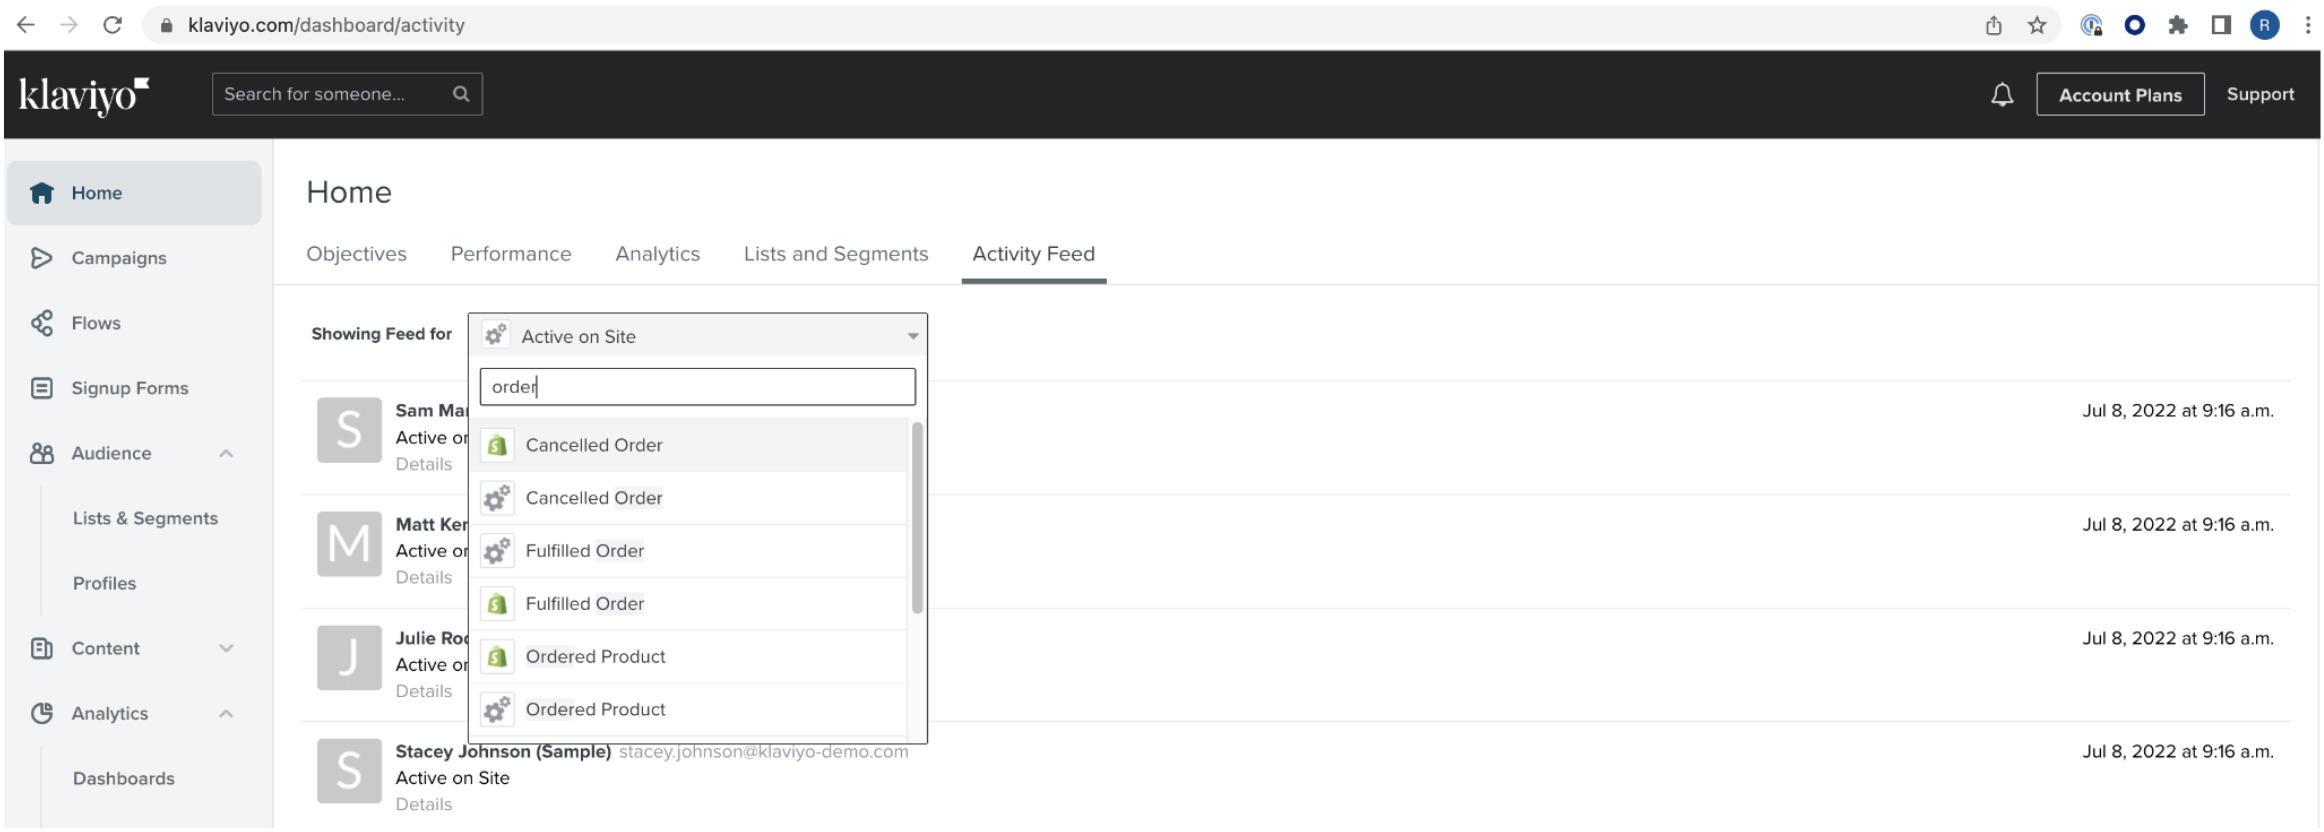

#### Step 2: Pull *Ordered Product* events within the BFCM date range

Note: for more detail on how to filter events, [please see Klaviyo's filtering documentation](https://developers.klaviyo.com/en/v2022-09-07.pre/docs/beta-api-overview#filtering).

In [18]:
bfcm_2021_start_utc = '2021-11-24T00:00:00' # thanksgiving day (thursday)
bfcm_2021_end_utc = '2021-11-29T00:00:00' # giving tuesday

# Filter here is read as "A and B and C". 
# Note that datetime strings are UTC and strings like metric_id need quotes surrounding
total_filter = "greater-than(datetime,{}),less-than(datetime,{}),equals(metric_id,'{}')".format(date_start_str, 
                                                                                                date_end_str, 
                                                                                                ordered_product_metric_id)

# Note: does not include pagination 
ordered_product_events = klaviyo.Events.get_events(filter=total_filter)

# display output
ordered_product_events

{'data': [{'type': 'event',
   'id': '3xLmpbZdFTJ',
   'attributes': {'metric_id': 'XT5zvt',
    'profile_id': '01G7EZ900W8H4TD8DH7HNH7MY3',
    'timestamp': 1660151407,
    'event_properties': {'Categories': ['Fiction', 'Classics'],
     'ImageURL': 'http://www.example.com/path/to/product/image.png',
     'Ordered Product Value': 19.99,
     'OrderId': 1235,
     'ProductBrand': 'Harcourt Classics',
     'ProductID': 1112,
     'ProductName': 'A Tale of Two Cities',
     'ProductURL': 'http://www.example.com/path/to/product',
     'Quantity': 1,
     'SKU': 'TALEOFTWO',
     '$event_id': 'ofurhjzbut',
     '$value': 0.0},
    'datetime': '2022-08-10 17:10:07+00:00',
    'uuid': '48618180-18cf-11ed-8001-596c00eb5f8c'},
   'links': {'self': 'https://a.klaviyo.com/api/events/3xLmpbZdFTJ/'}},
  {'type': 'event',
   'id': '3xKYGAANvxK',
   'attributes': {'metric_id': 'XT5zvt',
    'profile_id': '01G7EZ900W8H4TD8DH7HNH7MY3',
    'timestamp': 1660147395,
    'event_properties': {'Categories'

Eagle-eyed developers may notice that the printouts for this example are using a different date range than Black Friday - Cyber Monday. This is simply because the test account used to generate the outputs did not have any events during that time period.

#### Step 3: See if any of these purchase events were an account's first purchase

Unlike other code snippets shown in this guide, the block below uses a direct call to Klaviyo's V1 APIs rather than an indirect call through an SDK on Klaviyo's new APIs.

At the time of this guide's creation, the newest generation of Klaviyo's APIs is still in its early stages. At this point, the task below can only be done through the V1 APIs. 

This functionality is a planned part of Klaviyo's new generation of APIs that is under development. As the new generation of APIs continue their development cycle, the code below will be updated to reflect how Klaviyo recommends developers use our APIs.

In [19]:
# convert start date from string to datetime 
date_start_dt = datetime.strptime(date_start_str, '%Y-%m-%dT%H:%M:%S')
date_end_dt = datetime.strptime(date_end_str, '%Y-%m-%dT%H:%M:%S')

# output set of profile_ids
bfcm_2021_first_time_buyers = set()

In [20]:
# Note: This code snippet makes a direct call onto Klaviyo's V1 APIs

# Task: Iterate through BFCM 2021 orders to see if the customer's first order fits in the time range.
for order_event in ordered_product_events['data']:
    
    # get relevant profile_ids
    profile_id = order_event['attributes']['profile_id']

    # grabs the profile's first Ordered Product (count=1, sorted ascending by date)
    url = "https://a.klaviyo.com/api/v1/person/{}/metric/{}/timeline"\
            "?count=1&sort=asc&api_key={}".format(profile_id, ordered_product_metric_id, private_key)

    # header necessary for V1 APIs
    headers = {"Accept": "application/json"}
    response = requests.get(url, headers=headers)
    
    # convert json to dict
    data = json.loads(response.text)
    
    # reformat first purchase date into a datetime object
    first_event_datetime_str = data['data'][0]['datetime']
    first_event_datetime = datetime.strptime(first_event_datetime_str[:-6], '%Y-%m-%d %H:%M:%S')

    if (first_event_datetime > date_start_dt) and (first_event_datetime < date_end_dt):
        # if customer first bought product in the given range, add to set
        bfcm_2021_first_time_buyers.add(profile_id)    

After that loop, we are left with the `profile_ids` of accounts that meet the given criteria:

- Ordered a product between given date range (BFCM 2021)
- That event was their first purchase 

Let's next take a look at how we can use this information

In [21]:
# set of profile_ids
bfcm_2021_first_time_buyers

{'01G7EZ8ZSJZ8B633X2ZPZKZDKD',
 '01G7EZ8ZW2PAH2JE7BDWD6YR6E',
 '01G7EZ8ZYBH1QQWK9M04QZ57F0',
 '01G7EZ900W8H4TD8DH7HNH7MY3'}

#### Step 4: Create a new list in your Klaviyo account

Now that we have the profiles we wanted, we may want to save them for later use. We can do that by creating a list and uploading profiles to it.

Let's first take a look at how to create a list with Klaviyo's Python SDK.

Creating a list using Klaviyo's APIs requires passing a body describing the list to be created. [This is fully detailed in Klaviyo's documentation.](https://developers.klaviyo.com/en/v2022-09-07.pre/reference/create_list)

In [22]:
# body describing new list 
body = {
    'data': {
        'type': 'list',
        'attributes': {
            'name': '2021 BFCM First Time Buyers'
        }
    }
}

response = klaviyo.Lists.create_list(body)

# response object confirms metadata on newly created list
print(response)

# list_id is saved for future use in code blocks below
bfcm_2021_list_id = response['data']['id']

{'data': {'type': 'list', 'id': 'UKSuDW', 'attributes': {'name': '2021 BFCM First Time Buyers', 'created': '2022-10-19T22:04:29.688864+00:00', 'updated': '2022-10-19T22:04:29.688882+00:00'}, 'links': {'self': 'https://a.klaviyo.com/api/lists/UKSuDW/'}}}


Note: You may notice if you end up running the cell more than once that an account can have multiple lists with the same name. If your pipeline to create Lists is not configured well, you can end up creating many duplicate Lists.

In short, `list_ids` are unique, but list `names` are not.

#### Step 5: Add matching profiles to the new list

After pulling the relevant profile_ids and creating a new list to house them, the next step is to upload the profiles to the list.

This can be done using Klaviyo's SDK as shown below:


In [23]:
# Iteratively adds profiles to the list. At this point, this process must be done one-by-one.

for profile_id in bfcm_2021_first_time_buyers:
    
    payload = {
        'data': [
            {
                'type': 'profile',
                'id': profile_id
            }
        ]
    }

    klaviyo.Lists.create_list_relationships(bfcm_2021_list_id, list_members_add_query=payload)

#### Take a look in Klaviyo

The newly created list is now visible - along with its uploaded profiles - in the **Lists & Segments** tab.

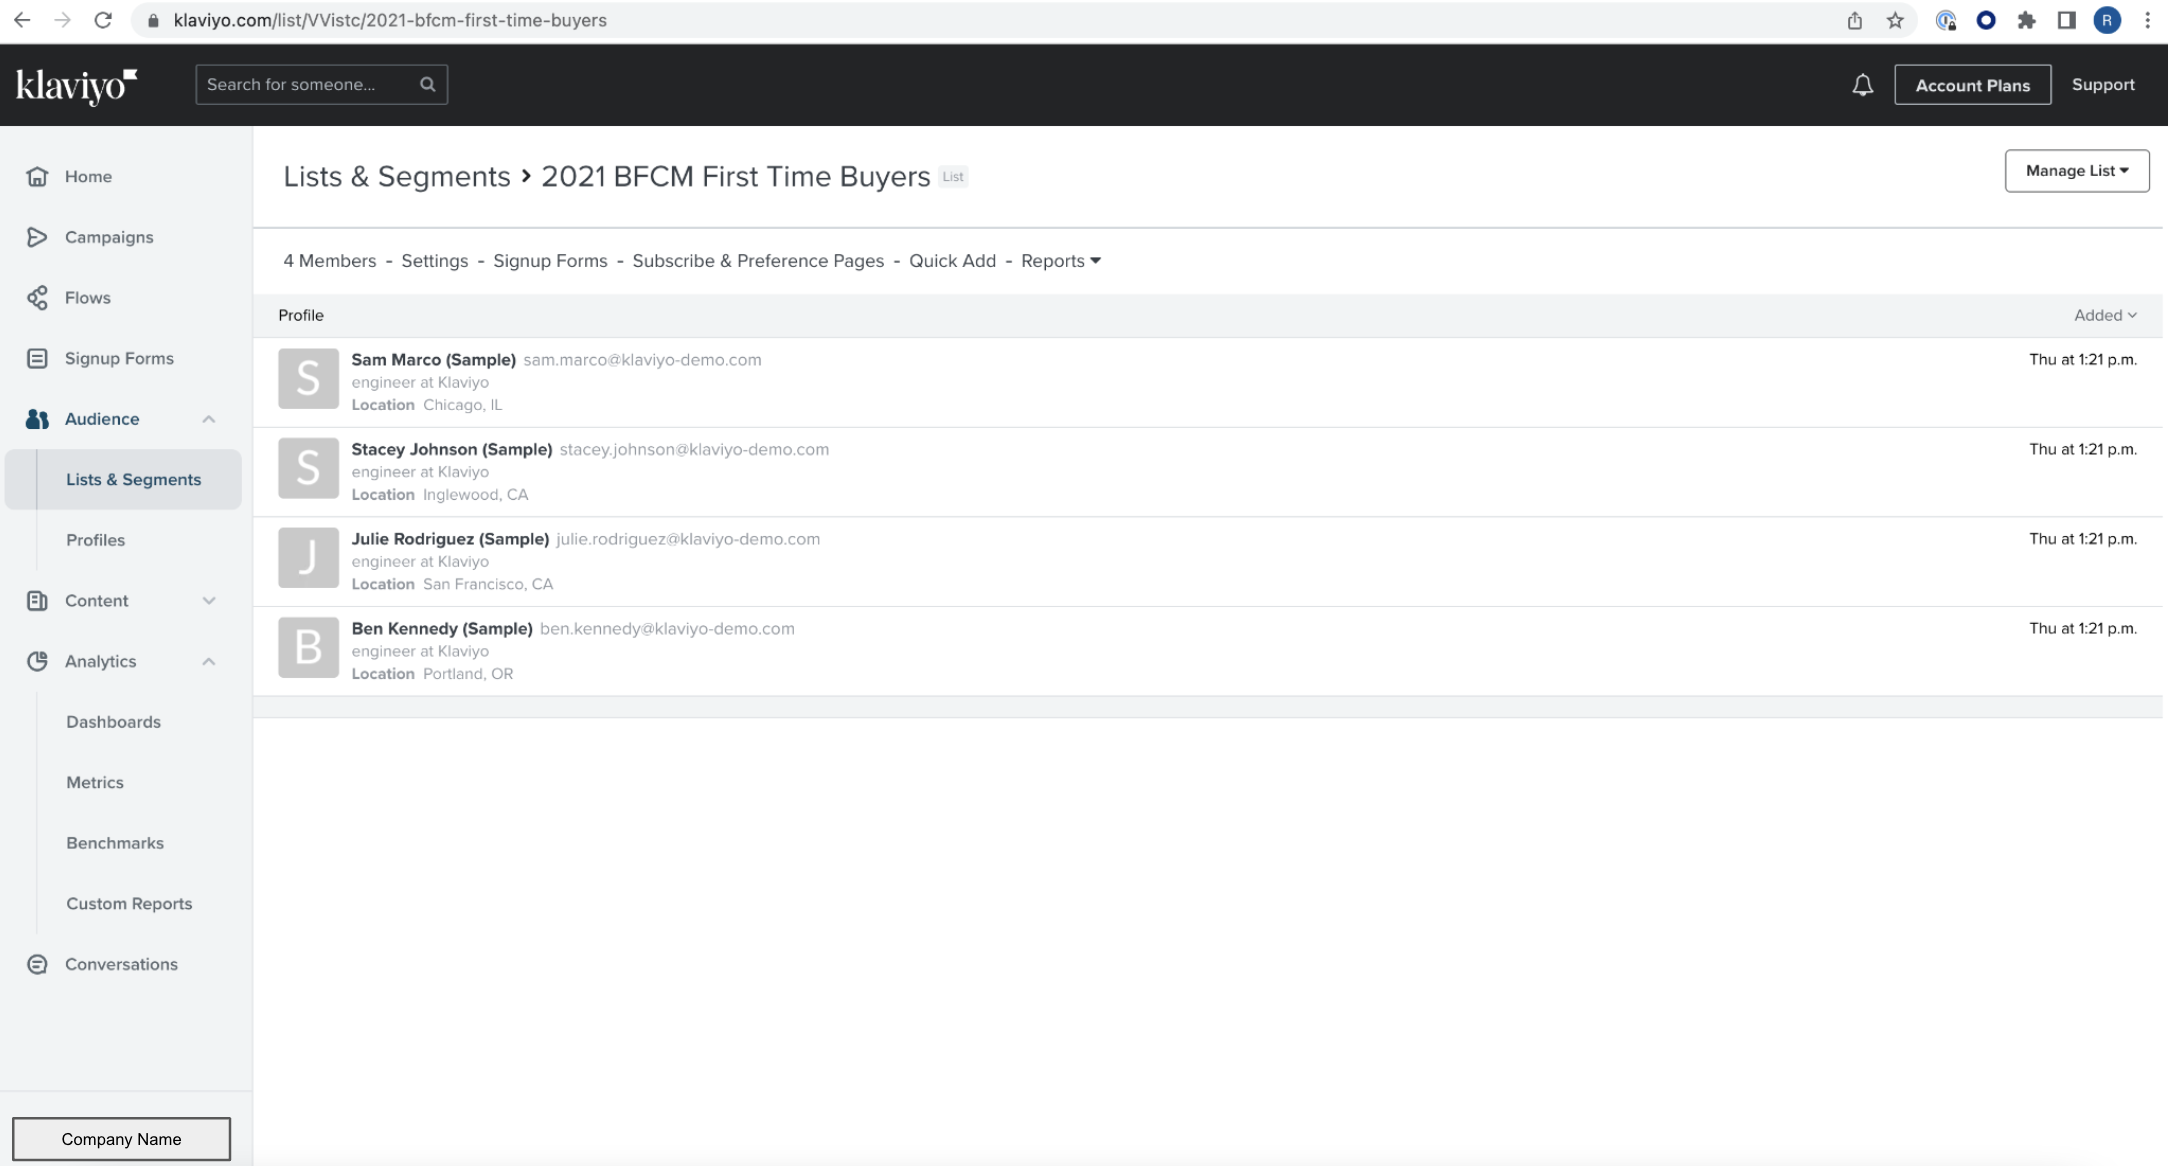

#### Summary: Finding first time buyers during BFCM

To summarize, we took a fairly complex request -- finding customers who made their first purchase during Black Friday / Cyber Monday -- and broke it into a number of smaller tasks:

1. Find the metric_id for *Ordered Product*
2. Pull *Ordered Product* events within the BFCM date range
3. See if any of these purchase events were an account's first purchase
4. Create a new list in your Klaviyo account
5. Add matching profiles to the new list

This example chained together data and calls from the `metrics`, `profiles`, `events`, and `lists` endpoints and included the concepts such as filtering, sorting, and pagination.

Most developers use Klaviyo's APIs to launch simpler integrations and analyses -- especially when they are new to Klaviyo. This example is not meant to be a blueprint, but rather a spark for your imagination. 

Developers able to follow along with this example should be well on their way to being able to dive into Klaviyo's data ecosystem. 

<a id='conclusion'></a>

## 5. Wrapping up

Klaviyo lets businesses collect precise data on their customers and helps them use it to supercharge their growth. Developers -- especially those at larger businesses -- play a key role in turning this massive amount of information into actionable insights. Klaviyo's APIs are the best way for developers to take on this task.

To that end, Klaviyo's Developer Experience team is here to help. This new generation of APIs, paired with documentation and guides like this, aim to give developers more powerful tools and make their lives easier. 

This guide started from the basics of how customer data in Klaviyo is structured to chaining together multiple endpoints to unlock net new functionality.

Developers with any more questions after reading this guide, should consider looking through the other guided code walkthroughs that are part of Klaviyo's documentation or reaching out to our talented Solution Architects:

- [API Documentation](https://developers.klaviyo.com/en/reference/api-overview)
- [Klaviyo SDKs](https://developers.klaviyo.com/en/docs/sdk-overview)
- [JS SDK Documentation](https://developers.klaviyo.com/en/docs/javascript-api)
- [API Guides Repository](https://github.com/klaviyo-labs/klaviyo-api-guides-public)
- [Klaviyo Developer Community Q&A](https://community.klaviyo.com/groups/developer-group-64)
- [Klaviyo Help Center](https://help.klaviyo.com/hc/en-us)
- [Support Requests](https://help.klaviyo.com/hc/en-us/requests/new)